# Policy gradients


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1000):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [4]:
batch[0], batch[0][1].shape

([0,
  array([ 0.03366609, -0.15008877,  0.04374749,  0.28982091]),
  1.0,
  False,
  {}],
 (4,))

In [5]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [6]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print(np.max(np.array(actions)), np.min(np.array(actions)))
print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print(np.max(np.array(rewards)), np.min(np.array(rewards)))
print(np.max(np.array(states)), np.min(np.array(states)))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(1000,) (1000, 4) (1000,) (1000,)
float64 float64 int64 bool
1 0
2
1.0 1.0
2.394872008144514 -2.8101446429452417


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [7]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    return states, actions

In [8]:
# Generator: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [10]:
def model_loss(states, actions, # model input
               action_size, hidden_size): # model init
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                     labels=actions_labels))        
    return actions_logits, loss

In [11]:
def model_opt(loss, learning_rate):
    """
    Get optimization operations in order
    :param loss: Generator loss Tensor for action prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=g_vars)

    return opt

In [13]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions) # model input
        
        # Update the model: backward pass and backprop
        self.opt = model_opt(loss=self.loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [14]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print(np.max(actions) - np.min(actions)+1)

state size:(1000, 4) actions:(1000,)
2


In [15]:
# Training parameters
train_episodes = 1000          # max number of episodes to learn from
max_steps = 300000000          # max steps in an episode
learning_rate = 0.001          # learning rate for adam

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
action_size = 2                # number of units for the output actions -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation

In [16]:
# Reset/init the graph/session
tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [17]:
env.reset()

array([ 0.00373198,  0.01359097, -0.02535178,  0.02129507])

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [18]:
state, reward, action

(array([-0.10783574, -1.1875493 , -0.0121092 ,  1.28097825]), 1.0, 0)

In [20]:
# Now train with experiences
saver = tf.train.Saver()
rewards_list, loss_list = [], []

# TF session for training
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(train_episodes):
        state = env.reset() # env first state
        batch = [] # every data batch

        # Training steps/batches
        for _ in range(max_steps): # start=0, step=1, stop=max_steps/done/reward
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            next_state, _, done, _ = env.step(action)
            reward = 1 - float(done)
            action *= reward # last action is always 0
            batch.append([state, action])
            state = next_state
            if done is True:
                break
                
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        loss, _ = sess.run([model.loss, model.opt], feed_dict = {model.states: states, model.actions: actions})
        print('Episode: {}'.format(ep),
              'Total reward: {}'.format(len(batch)),
              'Batch loss: {:.9f}'.format(loss))
        rewards_list.append((ep, len(batch)))
        loss_list.append((ep, loss))
        
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model-pg.ckpt')

Episode: 0 Total reward: 10 Batch loss: 0.628979862
Episode: 1 Total reward: 9 Batch loss: 0.615615845
Episode: 2 Total reward: 8 Batch loss: 0.612026989
Episode: 3 Total reward: 9 Batch loss: 0.588446915
Episode: 4 Total reward: 9 Batch loss: 0.574204087
Episode: 5 Total reward: 10 Batch loss: 0.544946015
Episode: 6 Total reward: 8 Batch loss: 0.573334455
Episode: 7 Total reward: 11 Batch loss: 0.512611926
Episode: 8 Total reward: 9 Batch loss: 0.538821995
Episode: 9 Total reward: 9 Batch loss: 0.533352971
Episode: 10 Total reward: 9 Batch loss: 0.529611170
Episode: 11 Total reward: 9 Batch loss: 0.521357775
Episode: 12 Total reward: 8 Batch loss: 0.544503033
Episode: 13 Total reward: 11 Batch loss: 0.478266209
Episode: 14 Total reward: 9 Batch loss: 0.511960208
Episode: 15 Total reward: 8 Batch loss: 0.532965600
Episode: 16 Total reward: 9 Batch loss: 0.506709099
Episode: 17 Total reward: 9 Batch loss: 0.504009366
Episode: 18 Total reward: 8 Batch loss: 0.523108959
Episode: 19 Total 

Episode: 158 Total reward: 29 Batch loss: 0.145020619
Episode: 159 Total reward: 38 Batch loss: 0.180302605
Episode: 160 Total reward: 48 Batch loss: 0.154559493
Episode: 161 Total reward: 44 Batch loss: 0.174218878
Episode: 162 Total reward: 53 Batch loss: 0.150148034
Episode: 163 Total reward: 54 Batch loss: 0.145538792
Episode: 164 Total reward: 38 Batch loss: 0.126124680
Episode: 165 Total reward: 45 Batch loss: 0.133654043
Episode: 166 Total reward: 55 Batch loss: 0.124975301
Episode: 167 Total reward: 33 Batch loss: 0.107642770
Episode: 168 Total reward: 49 Batch loss: 0.133978248
Episode: 169 Total reward: 74 Batch loss: 0.149139225
Episode: 170 Total reward: 86 Batch loss: 0.148345709
Episode: 171 Total reward: 44 Batch loss: 0.106963828
Episode: 172 Total reward: 58 Batch loss: 0.097674869
Episode: 173 Total reward: 78 Batch loss: 0.079450674
Episode: 174 Total reward: 123 Batch loss: 0.104544654
Episode: 175 Total reward: 76 Batch loss: 0.084700011
Episode: 176 Total reward: 

Episode: 309 Total reward: 200 Batch loss: 0.308612704
Episode: 310 Total reward: 200 Batch loss: 0.270952106
Episode: 311 Total reward: 200 Batch loss: 0.278924704
Episode: 312 Total reward: 200 Batch loss: 0.247263476
Episode: 313 Total reward: 200 Batch loss: 0.273161799
Episode: 314 Total reward: 200 Batch loss: 0.324429423
Episode: 315 Total reward: 200 Batch loss: 0.332074314
Episode: 316 Total reward: 200 Batch loss: 0.257243097
Episode: 317 Total reward: 200 Batch loss: 0.292590529
Episode: 318 Total reward: 200 Batch loss: 0.297063738
Episode: 319 Total reward: 101 Batch loss: 0.053691968
Episode: 320 Total reward: 92 Batch loss: 0.096517280
Episode: 321 Total reward: 81 Batch loss: 0.056043390
Episode: 322 Total reward: 200 Batch loss: 0.321490407
Episode: 323 Total reward: 200 Batch loss: 0.324211240
Episode: 324 Total reward: 200 Batch loss: 0.321777433
Episode: 325 Total reward: 115 Batch loss: 0.046058111
Episode: 326 Total reward: 200 Batch loss: 0.241278589
Episode: 327

Episode: 461 Total reward: 200 Batch loss: 0.272214264
Episode: 462 Total reward: 113 Batch loss: 0.034089826
Episode: 463 Total reward: 200 Batch loss: 0.293659836
Episode: 464 Total reward: 81 Batch loss: 0.038490355
Episode: 465 Total reward: 94 Batch loss: 0.040055931
Episode: 466 Total reward: 89 Batch loss: 0.039102841
Episode: 467 Total reward: 200 Batch loss: 0.356817216
Episode: 468 Total reward: 200 Batch loss: 0.292815804
Episode: 469 Total reward: 200 Batch loss: 0.275025100
Episode: 470 Total reward: 200 Batch loss: 0.348910034
Episode: 471 Total reward: 84 Batch loss: 0.038907144
Episode: 472 Total reward: 200 Batch loss: 0.296365708
Episode: 473 Total reward: 200 Batch loss: 0.237815171
Episode: 474 Total reward: 67 Batch loss: 0.116612136
Episode: 475 Total reward: 98 Batch loss: 0.035417795
Episode: 476 Total reward: 200 Batch loss: 0.267973870
Episode: 477 Total reward: 200 Batch loss: 0.291380227
Episode: 478 Total reward: 200 Batch loss: 0.337259978
Episode: 479 Tot

Episode: 612 Total reward: 200 Batch loss: 0.271116644
Episode: 613 Total reward: 200 Batch loss: 0.342822760
Episode: 614 Total reward: 80 Batch loss: 0.037600745
Episode: 615 Total reward: 200 Batch loss: 0.336481869
Episode: 616 Total reward: 200 Batch loss: 0.293675542
Episode: 617 Total reward: 200 Batch loss: 0.174484536
Episode: 618 Total reward: 200 Batch loss: 0.298290938
Episode: 619 Total reward: 200 Batch loss: 0.295098335
Episode: 620 Total reward: 124 Batch loss: 0.038374793
Episode: 621 Total reward: 98 Batch loss: 0.039978817
Episode: 622 Total reward: 200 Batch loss: 0.322073340
Episode: 623 Total reward: 200 Batch loss: 0.275782466
Episode: 624 Total reward: 200 Batch loss: 0.293488741
Episode: 625 Total reward: 200 Batch loss: 0.233543947
Episode: 626 Total reward: 200 Batch loss: 0.324133873
Episode: 627 Total reward: 200 Batch loss: 0.294593900
Episode: 628 Total reward: 110 Batch loss: 0.032217920
Episode: 629 Total reward: 200 Batch loss: 0.316675901
Episode: 630

Episode: 763 Total reward: 200 Batch loss: 0.299240559
Episode: 764 Total reward: 200 Batch loss: 0.270021826
Episode: 765 Total reward: 200 Batch loss: 0.311110407
Episode: 766 Total reward: 200 Batch loss: 0.248187020
Episode: 767 Total reward: 200 Batch loss: 0.265571356
Episode: 768 Total reward: 200 Batch loss: 0.268676639
Episode: 769 Total reward: 200 Batch loss: 0.232290938
Episode: 770 Total reward: 165 Batch loss: 0.040104151
Episode: 771 Total reward: 200 Batch loss: 0.287699133
Episode: 772 Total reward: 200 Batch loss: 0.324078530
Episode: 773 Total reward: 200 Batch loss: 0.283417940
Episode: 774 Total reward: 200 Batch loss: 0.305849463
Episode: 775 Total reward: 200 Batch loss: 0.132034063
Episode: 776 Total reward: 200 Batch loss: 0.220067784
Episode: 777 Total reward: 200 Batch loss: 0.313193679
Episode: 778 Total reward: 200 Batch loss: 0.290630937
Episode: 779 Total reward: 200 Batch loss: 0.160386786
Episode: 780 Total reward: 200 Batch loss: 0.199393883
Episode: 7

Episode: 913 Total reward: 129 Batch loss: 0.057168517
Episode: 914 Total reward: 97 Batch loss: 0.089661606
Episode: 915 Total reward: 200 Batch loss: 0.222587064
Episode: 916 Total reward: 200 Batch loss: 0.194761217
Episode: 917 Total reward: 200 Batch loss: 0.277492821
Episode: 918 Total reward: 200 Batch loss: 0.211509824
Episode: 919 Total reward: 200 Batch loss: 0.179371715
Episode: 920 Total reward: 200 Batch loss: 0.285262167
Episode: 921 Total reward: 200 Batch loss: 0.257037073
Episode: 922 Total reward: 200 Batch loss: 0.201692909
Episode: 923 Total reward: 200 Batch loss: 0.230265602
Episode: 924 Total reward: 200 Batch loss: 0.220524490
Episode: 925 Total reward: 197 Batch loss: 0.063829035
Episode: 926 Total reward: 200 Batch loss: 0.219456926
Episode: 927 Total reward: 200 Batch loss: 0.279229701
Episode: 928 Total reward: 200 Batch loss: 0.217901424
Episode: 929 Total reward: 200 Batch loss: 0.215324864
Episode: 930 Total reward: 200 Batch loss: 0.283574075
Episode: 93

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

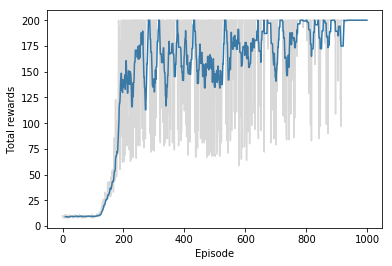

In [26]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Batch losses')

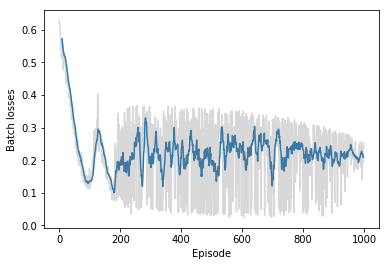

In [27]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Batch losses')

## Testing

Let's checkout how our trained agent plays the game.

In [29]:
import gym
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    #sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model-pg.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()

        # Steps/batches
        for _ in range(111111111111111111):
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, _, done, _ = env.step(action)
            if done:
                break
                
        # Closing the env
        env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model-pg.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.